In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb

/var/folders/1g/nb69w5095276sxhrps7sndf80000gn/T/ipykernel_52197/1549744002.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Exploratory Data Analysis (EDA)

In [13]:
df = pd.read_csv('case1Data.txt')
df.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,90.685036,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,-4.994792,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


### Data Preparation

In [17]:
# Replace Nan with 0 (we need to argue what to do with missing values and probably try with imputing mean, median, etc.)
df.replace(to_replace=r'^\s*NaN\s*$', value=np.nan, regex=True, inplace=True)  # Case-insensitive, trims whitespace
df.fillna(0, inplace=True)

# Cast numerical values to floats
df.iloc[:, :-5] = df.iloc[:, :-5].astype(float)

# TODO: Deal with categorical data (one hot encode?)


### Response variable (dependent variable)

Text(0.5, 1.0, 'Distribution of the dependent variable y')

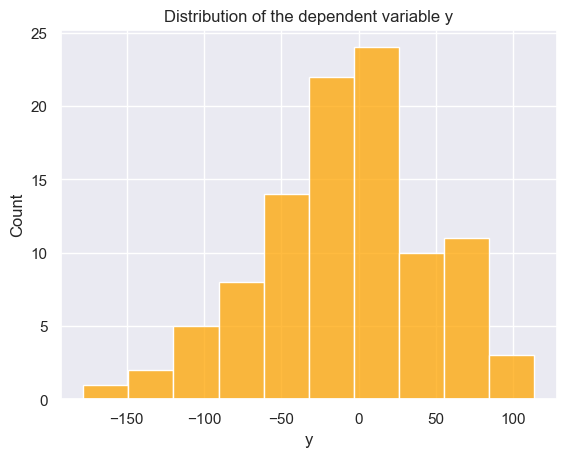

In [23]:
sns.set_theme(context='notebook', style='darkgrid', palette='flare', font='sans-serif', font_scale=1, color_codes=True, rc=None)

sns.histplot(df['y'], color="orange")
plt.title("Distribution of the dependent variable y")

### Feature variables (independent variables)

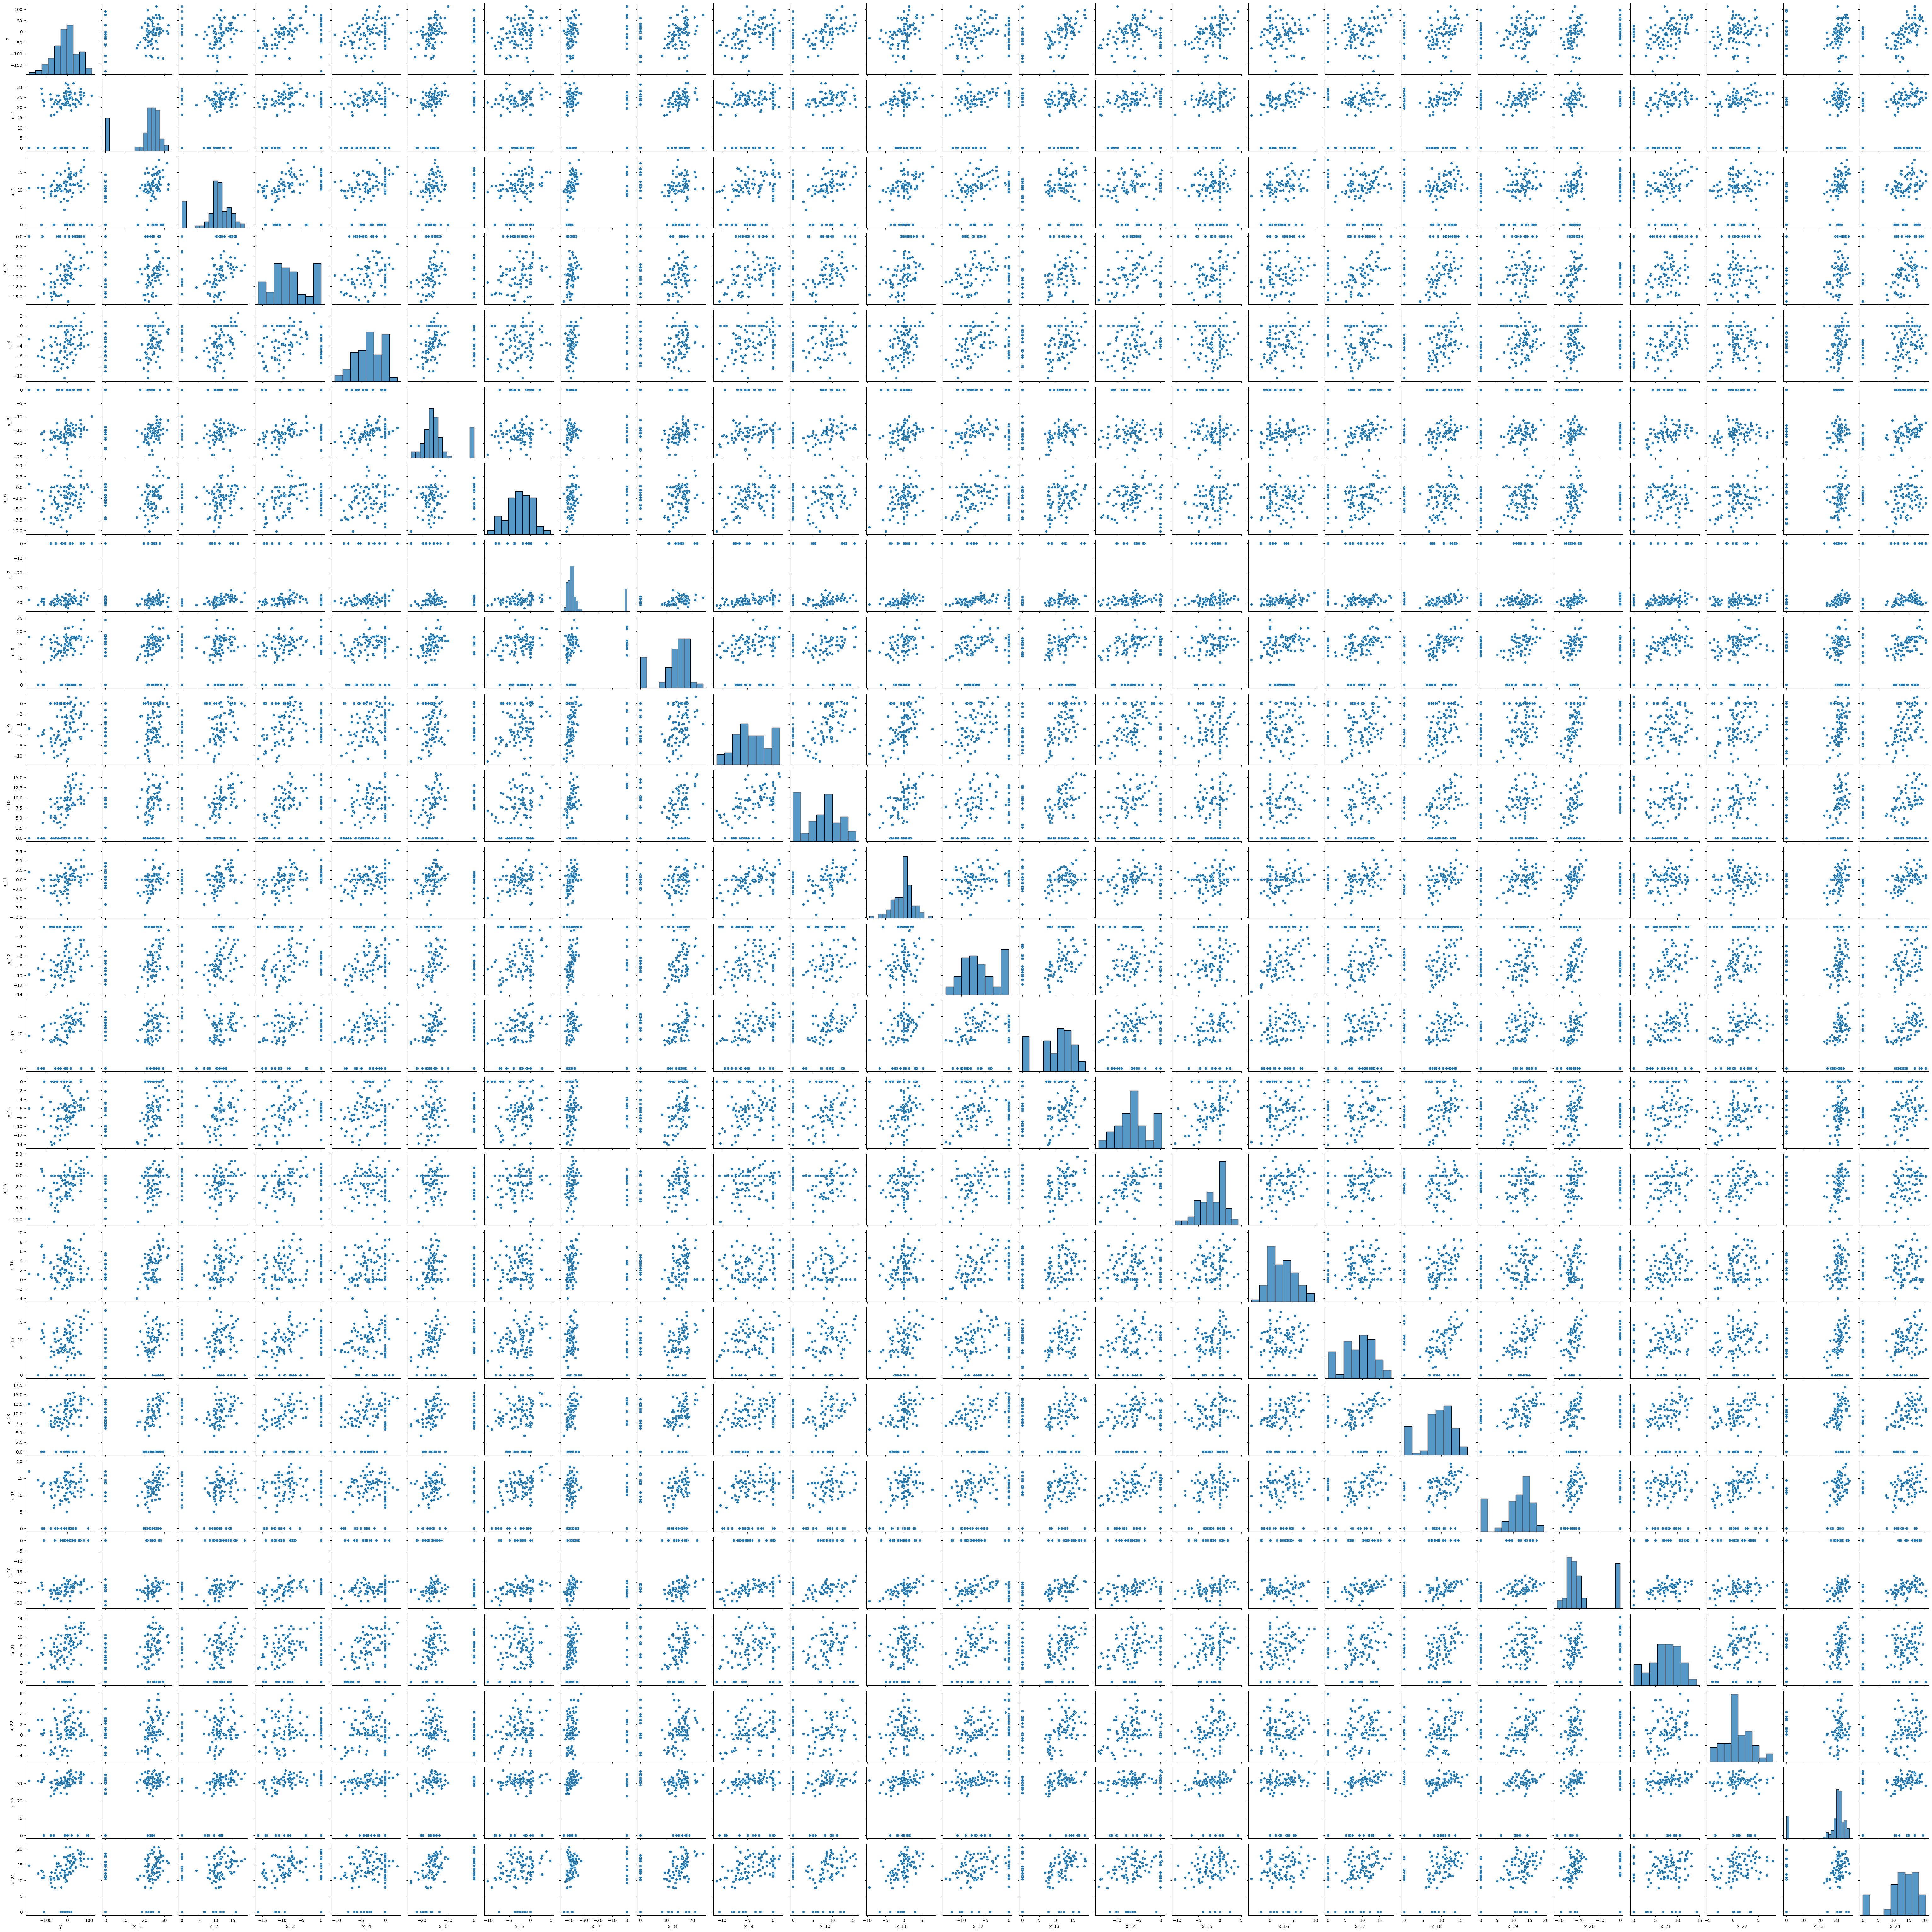

In [18]:
# First 25
sns.pairplot(df.iloc[:, :25])

Notes about data:

-Has 95 rows of integers with NaNs in them

-Then last 5 rows of Letters from : ['G', 'H', 'I', 'J', 'K', 'N', 'a']

In [7]:
last_five_columns = df.iloc[:, -5:]
concatenated_text = ''.join(last_five_columns.astype(str).values.flatten())

unique_letters = set(letter for letter in concatenated_text if letter.isalpha())

print(unique_letters)
# Letters that appear and their mapping to numbers
letters = ['G', 'H', 'I', 'J', 'K', 'N', 'a']
mapping = {letter: i+1.0 for i, letter in enumerate(letters)}

# Apply the mapping to the last 5 columns of the DataFrame
for col in df.iloc[:, -5:].columns:
    df[col] = df[col].apply(lambda x: ''.join(str(mapping.get(letter, letter)) for letter in str(x)))

# Convert everything to floats
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='ignore')
X = df.drop('y', axis=1) 
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

{'J', 'G', 'K', 'I', 'H'}


/var/folders/1g/nb69w5095276sxhrps7sndf80000gn/T/ipykernel_52197/991644872.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[column] = pd.to_numeric(df[column], errors='ignore')


Linear Regression

In [10]:


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 43.50576556621277
Mean Squared Error (MSE): 3376.839544773491
Root Mean Squared Error (RMSE): 58.110580316956835
R-squared (R²): -0.022878824551715526


Random Forest Regression

In [19]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 31.814562712999997
Mean Squared Error (MSE): 1523.404525637632
Root Mean Squared Error (RMSE): 39.03081507780272
R-squared (R²): 0.5385453736133891


Support Vector Regression (with gridsearch for hyperparameters)

In [23]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # Negate because we set greater_is_better=False

Best Parameters: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
Best RMSE: 38.882985457986436
Mean Absolute Error (MAE): 45.44650564064601
Mean Squared Error (MSE): 3262.089955021803
Root Mean Squared Error (RMSE): 57.11470874496168
R-squared (R²): 0.011879985846802166


XgBoost (with gridsearch)

In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Best RMSE: 34.30831454395398
